In [21]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
#import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

#from fiona.crs import from_epsg
import shapely
from shapely.geometry import *


from geopy.distance import vincenty

#### Shape file/ for presentation

In [2]:
# nybb = gpd.read_file('nybb_17c/nybb.shp')

In [3]:
# Get the route files
# import subprocess
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/gtfs/2015/gtfs_nyct_bus_20150103.zip', 'gtfs_nyct_bus_20150103.zip'), shell=True)
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150128.csv.xz', 'bus_time_20150128.csv.xz'), shell=True)
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150129.csv.xz', 'bus_time_20150129.csv.xz'), shell=True)


# import zipfile
# import lzma
# zip = zipfile.ZipFile('gtfs_nyct_bus_20150103.zip')
# zip.extractall()

In [22]:
def convert_to_int64(row):
    try:
        return np.int64(row)
    except ValueError:
        return np.nan

def utc_to_est(row):
    try:
        return row - timedelta(hours=5)
    except:
        raise

csv_f = pd.read_csv
archive = pd.concat([csv_f("bus_time_20150128.csv"),
                     csv_f("bus_time_20150129.csv")])        
        
trips = pd.read_csv("trips.txt")
stops = pd.read_csv("stops.txt")
schedules = pd.read_csv("stop_times.txt")

C:\Users\parth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
archive.next_stop_id = archive.next_stop_id.apply(convert_to_int64)

In [24]:
#query and clean
live_archive = archive[archive.block_assigned > 0] # "assigned" to a route
today = live_archive[live_archive.service_date == 20150128] # due to time shift we get some dates in 1/27 and 1/29
#throw away trips with <15 reports
good_trips_only = today.groupby(today.trip_id).filter(lambda group: len(group) > 15)

#write this as our "clean" dataset
good_trips_only.to_csv("realtime.csv")

#merged dataframe with both 
partial = good_trips_only.merge(trips, on='trip_id') 
df = partial.merge(stops, left_on="next_stop_id", right_on="stop_id")

In [25]:
# Select one bus route 
pd.options.display.max_columns = None
m15_only = df[df.route_id.str.contains("M15")].reset_index()
m15_only["timestamp"] = pd.to_datetime(m15_only["timestamp"])

In [26]:
m15_reg = m15_only[m15_only.trip_id.str.contains("M15")].reset_index()
m15_sbs = m15_only[m15_only.trip_id.str.contains("SBS")].reset_index()

In [27]:
print('The number of regular M15 buses over 48 hours =',len(m15_reg.trip_id.unique()))
print('The number of express M15 buses over 48 hours =',len(m15_sbs.trip_id.unique()))

The number of regular M15 buses over 48 hours = 257
The number of express M15 buses over 48 hours = 335


## Analysis

In [28]:
def split_direction(df):
    df_1 = df[df.direction_id == 1]
    
    df_1 = df_1[df_1.trip_id == df_1.trip_id.values[0]]
    
    df_1.sort_values('timestamp')
    
    df_0 = df[df.direction_id == 0]
    
    df_0 = df_0[df_0.trip_id == df_0.trip_id.values[0]]
      
    df_0 = df_0.sort_values('timestamp')
    return (df_1, df_0)


#### It will split DataFrame into two bus's direction

In [29]:
m15_reg_1, m15_reg_0 = split_direction(m15_reg)

In [30]:
m15_sbs_1, m15_sbs_0 = split_direction(m15_sbs)

#### The typical NYC block length is 0.05 miles ~ 100 meters

## We need 1 and 2 for each direction!!!!

In [31]:
# >>> from geopy.distance import vincenty
def finding_busstop(df1_regular, df2_express, meters): # df1 is regular, df2 is express, meters is threshold
    

    #### cleaning filtered data by stop_name             for sharing stop in meters
    
    clean_df1 = df1_regular.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    clean_df2 = df2_express.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    
    #### finding shared busstops
    regular = []
    express = []

    
    for j in range(len(clean_df1)):
        sStop1 = (clean_df1.latitude[j], clean_df1.longitude[j])
    
        for i in range(len(clean_df2)):
            rStop1 = (clean_df2.latitude[i], clean_df2.longitude[i])
            dist = (vincenty(rStop1, sStop1).meters)
        
            if(dist <= meters):
            
                regular.append(j)
                express.append(i)
    ##### making a bus stop panda frame
    cols = {'regular_stop' : regular, 'express_stop' : express}
    EStops = pd.DataFrame(cols)
    EStops.drop_duplicates(subset = 'express_stop', keep = 'first', inplace= True)
    regular = EStops.regular_stop
    express = EStops.express_stop
    
    ###### Finding the stop name  
    Share_Stop = clean_df1.iloc[regular,20].reset_index(drop = True)
    Share_eStop = clean_df2.iloc[express,20].reset_index(drop = True)
        
    
    return (Share_Stop, Share_eStop)




#### Finding Share_Stop and Share_eStop for analysis

In [32]:
Share_Stop, Share_eStop  = finding_busstop(m15_reg_1, m15_sbs_1, 100)

In [33]:
Share_Stop

0              2 AV/E 125 ST
1              2 AV/E 116 ST
2               2 AV/E 96 ST
3               2 AV/E 66 ST
4               2 AV/E 46 ST
5               2 AV/E 39 ST
6               2 AV/E 31 ST
7          ALLEN ST/CANAL ST
8     MADISON ST/ST JAMES PL
9         WATER ST/MAIDEN LA
10    WATER ST/GOUVERNEUR LA
Name: stop_name, dtype: object

In [34]:
Share_eStop

0               2 AV/E 125 ST
1               2 AV/E 106 ST
2               2 AV/E 100 ST
3                2 AV/E 57 ST
4                2 AV/E 42 ST
5                2 AV/E 34 ST
6                2 AV/E 28 ST
7     MADISON ST/CATHERINE ST
8          PEARL ST/FULTON ST
9            WATER ST/WALL ST
10       SOUTH FERRY/TERMINAL
Name: stop_name, dtype: object

In [35]:
def r_anaysis(df, Share_Stop):
### cleaning the clean_df1 and clean_df2 for only sharing bus_stop
    clean_df1 = df.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    clean_df1 = clean_df1
    SR = clean_df1[clean_df1.stop_name.isin(Share_Stop)].reset_index(drop = True) ## Sharing regular bus stop
#     SE = clean_df2[clean_df2.stop_name.isin(Share_eStop)].reset_index(drop = True) ## sharing expresss bus stop
#     df_join = SR.join(SE, lsuffix = '_regular', rsuffix = '_express')
    SR.dropna(axis = 0)
    
    
    #### calculating speed
#     express_speed = []
    regular_speed = []

    for i in range(len(SR)-1):
##             for SBS bus
#             ed = df_join.dist_along_route_express.values.astype(float)[i+1] \
#             - df_join.dist_along_route_express.values.astype(float)[i]
        
#             et = (df_join.timestamp_express[i+1] - df_join.timestamp_express[i]).seconds
#             express_speed.append(((ed/1000 * 0.625) /et) * 3600)
            
            # Regular bus

            rd = SR.dist_along_route.values.astype(float)[i+1] \
            - SR.dist_along_route.values.astype(float)[i]
        
            rt = (SR.timestamp[i+1] - SR.timestamp[i]).seconds
            regular_speed.append(((rd/1000 * 0.625) / rt) * 3600)
    
    ### making average_speed data frame
 
    cols = {'regular_mph' : regular_speed}
    mph = pd.DataFrame(cols)
    df_regular =  SR.join(mph)
    return (df_regular)
    
    

### regular _ Analysis

In [54]:
r_anaysis(m15_reg, Share_Stop )

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
0,0,161849,2015-01-28 05:23:55,6786,40.803310,-73.933166,233.93,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401738,180.23,108.89,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,13.153500
1,1079,162928,2015-01-28 05:26:00,6786,40.796702,-73.937992,234.01,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401741,910.98,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN,23.098443
2,1989,163838,2015-01-28 05:28:39,6786,40.787300,-73.944873,234.10,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,803182,2543.27,437.1,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,10.896205
3,5264,167113,2015-01-28 05:37:03,6786,40.765665,-73.960653,233.73,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401762,4984.02,129.36,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401762,2 AV/E 66 ST,NaN,40.764698,-73.961517,NaN,NaN,0,NaN,11.100024
4,8226,170075,2015-01-28 05:42:17,6786,40.754562,-73.968748,233.75,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401769,6533.09,267.76,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401769,2 AV/E 46 ST,NaN,40.752502,-73.970398,NaN,NaN,0,NaN,10.894075
5,9509,171358,2015-01-28 05:44:24,6786,40.749309,-73.972581,233.65,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401772,7148,215.26,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
6,10066,171915,2015-01-28 05:45:28,6786,40.744383,-73.976171,233.91,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401775,7783.39,224.91,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401775,2 AV/E 31 ST,NaN,40.742668,-73.977577,NaN,NaN,0,NaN,10.968566
7,11976,174008,2015-01-28 05:57:42,6786,40.715803,-73.992260,242.87,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401793,11361.58,115.08,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401793,ALLEN ST/CANAL ST,NaN,40.714863,-73.992836,NaN,NaN,0,NaN,8.596110
8,13304,175336,2015-01-28 06:01:25,6786,40.712002,-73.997490,186.23,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,903054,12213.55,163.8,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,903054,MADISON ST/ST JAMES PL,NaN,40.711884,-73.999428,NaN,NaN,0,NaN,8.854809
9,14181,176506,2015-01-28 06:05:08,6786,40.706194,-74.005945,215.39,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401800,13091.16,33.61,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401800,WATER ST/MAIDEN LA,NaN,40.706055,-74.006317,NaN,NaN,0,NaN,15.996797


In [84]:
def e_anaysis(df, Share_eStop):
### cleaning the clean_df1 and clean_df2 for only sharing bus_stop
#     SR = clean_df1[clean_df1.stop_name.isin(Share_Stop)].reset_index(drop = True) ## Sharing regular bus stop
    clean_df2 = df.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    clean_df2 = clean_df2.sort_values('timestamp')
    SE = clean_df2[clean_df2.stop_name.isin(Share_eStop)].reset_index(drop = True) ## sharing expresss bus stop
#     df_join = SR.join(SE, lsuffix = '_regular', rsuffix = '_express')
#     df_join.dropna(axis = 0)
    
    
    #### calculating speed
    express_speed = []
#     regular_speed = []

    for i in range(len(SE)-1):
            # for SBS bus
            ed = SE.dist_along_route.values.astype(float)[i+1] \
            - SE.dist_along_route.values.astype(float)[i]
#         
            et = (SE.timestamp[i+1] - SE.timestamp[i]).seconds
            express_speed.append(((ed/1000 * 0.625) /et) * 3600)
            
#             # Regular bus

#             rd = df_join.dist_along_route_regular.values.astype(float)[i+1] \
#             - df_join.dist_along_route_regular.values.astype(float)[i]
        
#             rt = (df_join.timestamp_regular[i+1] - df_join.timestamp_regular[i]).seconds
#             regular_speed.append(((rd/1000 * 0.625) / rt) * 3600)
    
    ### making average_speed data frame
 
    cols = {'express_mph' : express_speed}
    mph = pd.DataFrame(cols)
    df_express = SE.join(mph)
    
    return(df_express)
    

In [85]:
e_anaysis(m15_sbs_1, Share_eStop)

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,express_mph
0,46,161895,2015-01-28 09:46:18,1273,40.803411,-73.933053,157.83,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401738,180.23,126.16,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,26.641260
1,41974,1831899,2015-01-28 09:48:23,1273,40.796655,-73.938026,234.01,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,405347,1660.3,743.33,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405347,2 AV/E 106 ST,NaN,40.790859,-73.942429,NaN,NaN,0,NaN,5.933452
2,42401,1832326,2015-01-28 09:51:32,1273,40.787643,-73.944623,233.82,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,903103,2158.71,96.08,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN,15.926407
3,5775,167624,2015-01-28 09:59:53,1273,40.765929,-73.960459,233.73,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401765,5704.99,883.88,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401765,2 AV/E 57 ST,NaN,40.759022,-73.965652,NaN,NaN,0,NaN,12.336341
4,8471,170320,2015-01-28 10:03:33,1273,40.753940,-73.969202,233.99,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401771,6911.21,566.84,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401771,2 AV/E 42 ST,NaN,40.749527,-73.972572,NaN,NaN,0,NaN,11.479680
5,32731,791726,2015-01-28 10:05:38,1273,40.749435,-73.972489,233.65,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401774,7548.97,632.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,8.008929
6,42884,1832809,2015-01-28 10:07:44,1273,40.744327,-73.976212,233.91,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403525,7997.47,431.89,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403525,2 AV/E 28 ST,NaN,40.740971,-73.978760,NaN,NaN,0,NaN,14.496367
7,12622,174654,2015-01-28 10:18:13,1273,40.715682,-73.992322,242.87,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,402112,12050.01,770.03,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,402112,MADISON ST/CATHERINE ST,NaN,40.712097,-73.997284,NaN,NaN,0,NaN,11.479615
8,13537,175846,2015-01-28 10:20:49,1273,40.711894,-73.998524,185.84,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403590,12845.93,689.25,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,5.116190
9,43633,1833558,2015-01-28 10:23:58,1273,40.706453,-74.005577,214.75,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403754,13275.69,241.48,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403754,WATER ST/WALL ST,NaN,40.705044,-74.007759,NaN,NaN,0,NaN,22.641786


In [86]:
def final_df(df_regular, df_express, Share_Stop = Share_Stop, Share_eStop = Share_eStop):

    my_a_0 = []

    for group in df_regular.groupby('trip_id'):
    
        a = r_anaysis(group[1], Share_Stop)
        my_a_0.append(a)
    my_df_r = pd.concat((my_a_0), axis=0)
    
    my_a_1 = []

    for group in df_express.groupby('trip_id'):
    
        a = e_anaysis(group[1], Share_eStop)
        my_a_1.append(a)
    my_df_e = pd.concat((my_a_1), axis=0)
    
    return (my_df_r, my_df_e)

In [87]:
my_df_r, my_df_e = final_df(m15_reg, m15_sbs)

In [88]:
my_df_e.iloc[:,[2,9,28]]

,timestamp,trip_id,express_mph
0,2015-01-28 09:46:18,OF_A5-Weekday-SDon-028500_SBS15_1,26.641260
1,2015-01-28 09:48:23,OF_A5-Weekday-SDon-028500_SBS15_1,5.933452
2,2015-01-28 09:51:32,OF_A5-Weekday-SDon-028500_SBS15_1,15.926407
3,2015-01-28 09:59:53,OF_A5-Weekday-SDon-028500_SBS15_1,12.336341
4,2015-01-28 10:03:33,OF_A5-Weekday-SDon-028500_SBS15_1,11.479680
5,2015-01-28 10:05:38,OF_A5-Weekday-SDon-028500_SBS15_1,8.008929
6,2015-01-28 10:07:44,OF_A5-Weekday-SDon-028500_SBS15_1,14.496367
7,2015-01-28 10:18:13,OF_A5-Weekday-SDon-028500_SBS15_1,11.479615
8,2015-01-28 10:20:49,OF_A5-Weekday-SDon-028500_SBS15_1,5.116190
9,2015-01-28 10:23:58,OF_A5-Weekday-SDon-028500_SBS15_1,22.641786


In [42]:
my_df_e.shape

(1981, 29)

In [78]:
test3 = m15_sbs[m15_sbs['trip_id'] == 'OF_A5-Weekday-SDon-028500_SBS15_1']

In [81]:
test4 = test3.drop_duplicates(subset = 'stop_name', keep = 'first')

In [82]:
test4.sort_values('timestamp')

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,46,161895,2015-01-28 09:46:18,1273,40.803411,-73.933053,157.83,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401738,180.23,126.16,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
418,1090,162939,2015-01-28 09:47:52,1273,40.799582,-73.935902,234.94,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401741,910.98,365.38,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
19084,41974,1831899,2015-01-28 09:48:23,1273,40.796655,-73.938026,234.01,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,405347,1660.3,743.33,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405347,2 AV/E 106 ST,NaN,40.790859,-73.942429,NaN,NaN,0,NaN
19511,42401,1832326,2015-01-28 09:51:32,1273,40.787643,-73.944623,233.82,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,903103,2158.71,96.08,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN
728,2701,164550,2015-01-28 09:52:34,1273,40.786363,-73.945557,233.68,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,405307,3129.23,903.97,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN
1579,3961,165810,2015-01-28 09:54:09,1273,40.778985,-73.950934,234.08,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401756,3919.63,757.23,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401756,2 AV/E 79 ST,NaN,40.773067,-73.955383,NaN,NaN,0,NaN
13709,31270,790265,2015-01-28 09:56:46,1273,40.772241,-73.955854,233.92,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401761,4815.56,796.38,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401761,2 AV/E 68 ST,NaN,40.766014,-73.960526,NaN,NaN,0,NaN
2206,5775,167624,2015-01-28 09:59:53,1273,40.765929,-73.960459,233.73,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401765,5704.99,883.88,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401765,2 AV/E 57 ST,NaN,40.759022,-73.965652,NaN,NaN,0,NaN
3955,8471,170320,2015-01-28 10:03:33,1273,40.753940,-73.969202,233.99,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401771,6911.21,566.84,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401771,2 AV/E 42 ST,NaN,40.749527,-73.972572,NaN,NaN,0,NaN
14454,32731,791726,2015-01-28 10:05:38,1273,40.749435,-73.972489,233.65,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401774,7548.97,632.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN


In [53]:
my_df_e[my_df_e.express_mph < 0.5]

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,express_mph
4,13537,175846,2015-01-28 10:20:49,1273,40.711894,-73.998524,185.84,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403590,12845.93,689.25,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139412
5,32731,791726,2015-01-28 10:05:38,1273,40.749435,-73.972489,233.65,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401774,7548.97,632.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155210
4,13545,175854,2015-01-28 10:30:12,1285,40.711799,-73.999490,185.54,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,403590,12845.93,607.2,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139421
5,32736,791731,2015-01-28 10:14:55,1285,40.747493,-73.973900,234.23,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401774,7548.97,385.74,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155223
4,13548,175857,2015-01-28 10:43:37,1258,40.711846,-73.999007,185.54,0,20150128,OF_A5-Weekday-SDon-030500_SBS15_3,1,403590,12845.93,648.23,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139536
5,32738,791733,2015-01-28 10:27:10,1258,40.748101,-73.973460,233.77,0,20150128,OF_A5-Weekday-SDon-030500_SBS15_3,1,401774,7548.97,462.89,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155226
4,13555,175864,2015-01-28 10:54:08,1249,40.711818,-73.999297,185.54,0,20150128,OF_A5-Weekday-SDon-031400_SBS15_4,1,403590,12845.93,623.61,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139698
5,32743,791738,2015-01-28 10:36:02,1249,40.747209,-73.974106,233.61,0,20150128,OF_A5-Weekday-SDon-031400_SBS15_4,1,401774,7548.97,349.74,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155409
4,13558,175867,2015-01-28 11:01:12,1268,40.711968,-73.997801,185.84,0,20150128,OF_A5-Weekday-SDon-032200_SBS15_5,1,403590,12845.93,750.8,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139474
5,32746,791741,2015-01-28 10:45:23,1268,40.745024,-73.975702,233.69,0,20150128,OF_A5-Weekday-SDon-032200_SBS15_5,1,401774,7548.97,72.01,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155438


In [89]:
testr = my_df_r[my_df_r.regular_mph > 0]
teste = my_df_e[my_df_e.express_mph > 0]

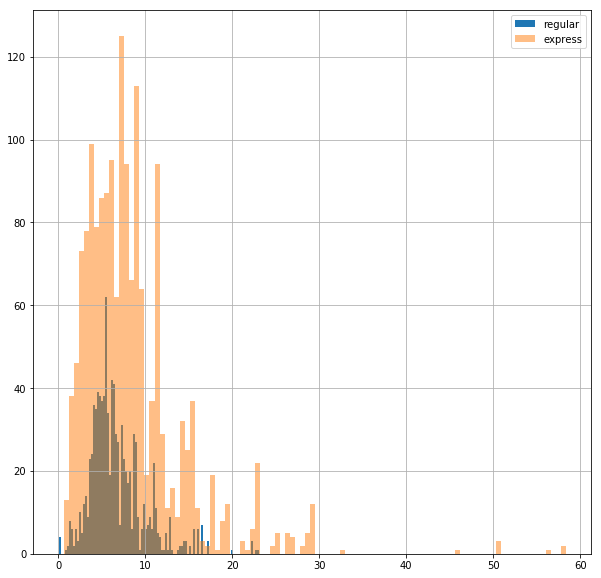

In [90]:
plt.figure(figsize=(10,10))
testr.regular_mph.hist(bins = 100, label = 'regular')
teste.express_mph.hist(bins = 100, alpha = 0.5, label = 'express')
plt.legend()

In [45]:
my_df_r[my_df_r.regular_mph < 1]

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
0,24,161873,2015-01-28 09:02:52,5622,40.803197,-73.932526,157.39,0,20150128,OH_A5-Weekday-SDon-024500_M15_6,1,401738,180.23,176.47,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,0.019107
1,2081,163930,2015-01-28 14:02:28,5550,40.786320,-73.945588,233.68,0,20150128,OH_A5-Weekday-SDon-052100_M15_9,1,803182,2543.27,312.56,M15,OH_A5-Weekday-SDon,PIKE ST - DIVISION ST via 2 AV,1,M150352,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.064153
0,431,162280,2015-01-28 17:43:13,5640,40.803421,-73.933078,157.83,0,20150128,OH_A5-Weekday-SDon-078500_M15_14,1,401738,180.23,123.77,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,0.915982
1,2330,164179,2015-01-28 22:59:17,5323,40.787175,-73.944963,234.10,0,20150128,OH_A5-Weekday-SDon-102600_M15_40,1,803182,2543.27,421.27,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.063818
2,2358,164207,2015-01-29 01:22:58,5257,40.785409,-73.946249,233.98,0,20150128,OH_A5-Weekday-SDon-116600_M15_46,1,803182,2543.27,197.05,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.064581


In [46]:
my_df_r[my_df_r.regular_mph > 20]

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
1,1079,162928,2015-01-28 05:26:00,6786,40.796702,-73.937992,234.01,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401741,910.98,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN,23.098443
5,9509,171358,2015-01-28 05:44:24,6786,40.749309,-73.972581,233.65,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401772,7148,215.26,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
4,9510,171359,2015-01-28 06:29:29,3904,40.748376,-73.973258,233.77,0,20150128,OH_A5-Weekday-SDon-006000_M15_3,1,401772,7148,96.87,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.692500
5,9513,171362,2015-01-28 07:23:23,6702,40.748800,-73.972951,234.21,0,20150128,OH_A5-Weekday-SDon-012000_M15_1,1,401772,7148,150.68,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
3,9516,171365,2015-01-28 09:14:27,5643,40.747995,-73.973537,233.77,0,20150128,OH_A5-Weekday-SDon-023000_M15_5,1,401772,7148,48.43,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
6,13319,175351,2015-01-28 09:28:35,5643,40.711806,-73.999417,185.56,0,20150128,OH_A5-Weekday-SDon-023000_M15_5,1,903054,12213.55,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,903054,MADISON ST/ST JAMES PL,NaN,40.711884,-73.999428,NaN,NaN,0,NaN,20.052581


In [47]:
my_df_r.regular_mph.describe()

count    943.000000
mean       6.701798
std        3.233917
min        0.019107
25%        4.610111
50%        6.049927
75%        8.125357
max       23.098443
Name: regular_mph, dtype: float64

In [48]:
my_df_r.regular_mph.mean() + 2 * my_df_r.regular_mph.std()

13.169631272064173

In [49]:
  my_df_r.regular_mph.mean() - 2 * my_df_r.regular_mph.std()

0.2339648873825988

In [50]:
from scipy import stats
np.random.seed(12345678)

In [51]:
my_df_r.regular_mph

0     13.153500
1     23.098443
2     10.896205
3     11.100024
4     10.894075
5     22.337930
6     10.968566
7      8.596110
8      8.854809
9     15.996797
10          NaN
0           NaN
0     12.904951
1     10.853137
2     12.272562
3     10.980536
4     22.692500
5     12.738809
6      7.488018
7     11.353973
8           NaN
0           NaN
0     10.276172
1     16.543480
2      9.229727
3     15.629630
4     12.353103
5      8.991368
6      9.201060
7     12.367306
        ...    
0     11.622318
1      7.533179
2      7.903418
3     11.032059
4      7.719010
5     12.875592
6           NaN
0           NaN
0     12.845215
1     16.469294
2      7.853976
3     10.894075
4     15.048711
5      8.215232
6      7.546978
7      6.904274
8           NaN
0           NaN
0           NaN
0      8.653618
1     14.574018
2      7.924513
3      7.384338
4      8.926113
5      9.105908
6      9.005512
7      6.846187
8      7.027126
9     15.996797
10          NaN
Name: regular_mph, Lengt

In [98]:
rvs1 = stats.norm.rvs(loc=6.702,scale=3.234,size=1140)
# >>> rvs2 = stats.norm.rvs(loc=5,scale=10,size=500)
# >>> stats.ttest_ind(rvs1,rvs2)
rvs2 = my_df_r.regular_mph

stats.ttest_ind(rvs1,rvs2, equal_var = False)

AttributeError: 'numpy.ndarray' object has no attribute 'values'